In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from data.flood_event_dataset import FloodEventDataset

In [ ]:
spin_up_timesteps = 2880 # 24 hours (2880 timesteps at 30 seconds interval)
timesteps_from_peak = 720 # 6 hours (720 timesteps at 30 seconds interval)
inflow_boundary_edges = [1849]
outflow_boundary_nodes = [1253, 1129]

dataset = FloodEventDataset(
    mode='train',
    root_dir='data/datasets',
    dataset_summary_file='train.csv',
    nodes_shp_file='Geometry/updated_cell_centers.shp',
    edges_shp_file='Geometry/links.shp',
    spin_up_timesteps=spin_up_timesteps,
    timesteps_from_peak=timesteps_from_peak,
    inflow_boundary_edges=inflow_boundary_edges,
    outflow_boundary_nodes=outflow_boundary_nodes,
)

In [3]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 12
Total number of timesteps: 167998


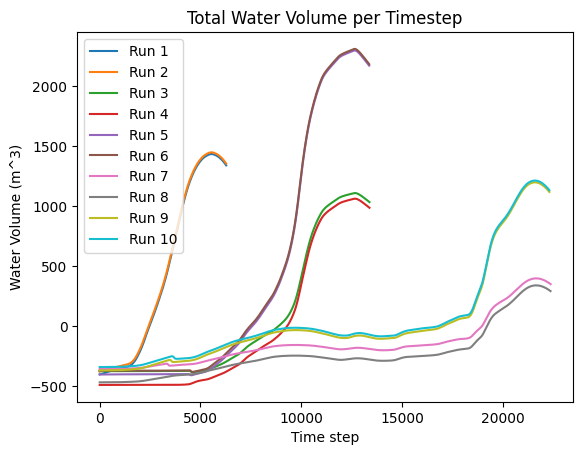

In [4]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[5:(num_events + 5)]

for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes']
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    total_water_volume = water_volume.sum(axis=1)
    plt.plot(total_water_volume, label=f'Run {run_id}')

plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time step')
plt.ylabel('Water Volume (m^3)')
plt.legend()
plt.show()

In [6]:
trimmed_dataset = dataset[:100]
for graph in tqdm(trimmed_dataset):
    non_boundary_edges_mask = ~np.isin(np.arange(graph.edge_index.shape[1]), graph.boundary_edges)
    non_boundary_edge_attr = graph.edge_attr[non_boundary_edges_mask, :]
    non_boundary_edge_attr.shape

    mid_edge_idx = non_boundary_edge_attr.shape[0] // 2
    num_dynamic_edge_dims = dataset.num_dynamic_edge_features * (dataset.previous_timesteps + 1)
    first_half_edge_attr = non_boundary_edge_attr[:mid_edge_idx, -num_dynamic_edge_dims:]
    second_half_edge_attr = non_boundary_edge_attr[mid_edge_idx:, -num_dynamic_edge_dims:]
    assert (first_half_edge_attr == -second_half_edge_attr).all(), "Dynamic edge attributes must be opposite in the two halves."

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]
